# Tutorial：7
- 使用フレームワーク : deap
- 選択手法 : NSGA-Ⅲ
- 設計変数 : 4個
  - 連続値 : 4個
- 目的変数 : 2個
- 制約条件 : 2パターン
  1. 連続値のmin,max
  2. 連続値の変数の比率に制約あり(一定制約)

## 習得してもらうこと
- 連続値の変数の比率に制約あり

## 実施内容
 - Part0. 取り扱う問題設定

 - Patr1: モジュールのimport 

 - Part2: 評価関数の作成
   - 目的関数の設計
   - ペナルティ関数の導入


 - Part3: 遺伝的アルゴリズムの設計
   - 遺伝的アルゴリズムにおける個体の表現
   - 遺伝子操作関数の設定
     - 交叉
     - 突然変異
   - 解の選択手法の設定


 - Part4: 最適化計算の実行
   - 初期状態の設定
   - 遺伝的最適化計算の実行  


 - Part5. 結果の確認
   - 初期世代と最終世代の目的関数の値を確認
   - 制約条件を満たした値であるか確認
   - ハイパーボリューム

# Part0. 取り扱う問題設定

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 + 4C^2 + D \\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2 - 4C -5D^2 \\
&s.t.& 0 & \leqq  A  \leqq 5 \\
& & 0& \leqq  B  \leqq 3 \\
& & 0& \leqq C \leqq 5 \\
& & 0& \leqq D \leqq 3 \\
& &1& = (A * B)　/　(C * D)
\end{align*}
$

# Part1. モジュールのimport

In [1]:
%load_ext lab_black

In [2]:
import random
from functools import partial
from math import isclose

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from deap import base, creator, tools
from deap.algorithms import varAnd
from deap.benchmarks.tools import hypervolume

# Part2. 評価関数の作成

### 目的関数

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 + 4C^2 + D\\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2 - 4C -5D^2
\end{align*}
$


In [3]:
# 評価関数
def objectfunction(individual):
    """
    individual(list): 個体の設計変数を格納するlist
    """
    # 教材用として、A, B, C, Dの変数を作成
    A = individual[0]
    B = individual[1]
    C = individual[2]
    D = individual[3]

    f1 = 4 * A ** 2 + 4 * B ** 2 + 4 * C ** 2 + D
    f2 = (A - 5) ** 2 + (B - 5) ** 2 - 4 * C - 5 * D ** 2
    return f1, f2

### ペナルティ関数

$
\begin{align*}
&s.t.& 0 & \leqq  A  \leqq 5 \\
& & 0& \leqq  B  \leqq 3 \\
& & 0& \leqq C \leqq 5 \\
& & 0& \leqq D \leqq 3 \\
& &1& = (A * B)　/　(C * D)
\end{align*}
$

In [4]:
# ペナルティ関数で判定したい制約条件のリスト
# 教材用にこちらで定義していますが。後ほど登場する「generator_config」から作れるようにした方が良いです
cases = [
    {
        "type": "minmax",
        "case": {
            0: {"min": 0, "max": 5},  # 設計変数:A
            1: {"min": 0, "max": 3},  # 設計変数:B
            2: {"min": 0, "max": 5},  # 設計変数:C
            3: {"min": 0, "max": 3},  # 設計変数:D
        },
    },
    {
        "type": "ratio",
        "case": {((0, 1), (2, 3)): {"value": 1}},  # 分子、分母の順
    },  # 複数変数間の比率制約,
]

#### 複数変数のパターン組み合わせに関する制約を満たしているかをjudge_ratioという関数でチェックします

In [5]:
# ペナルティ関数で使用する関数
# 可能範囲以内(連続値)
def judge_minmax(individual, case):
    for k, v in case.items():
        if not float(v["min"]) <= individual[int(k)] <= v["max"]:
            return False
    return True


# 複数変数の比率制約
def judge_ratio(individual, case):
    for (numerator_idxs, denominator_idxs), v in case.items():
        numerator = 1
        denominator = 1
        # 分子の計算
        for idx in numerator_idxs:
            numerator *= individual[int(idx)]
        # 分母の計算
        for idx in denominator_idxs:
            denominator *= individual[int(idx)]
        # 分母が0の場合にFalseを返す(比率の計算をスキップする)
        if denominator == 0:
            return False
        ratio = numerator / denominator
        # math.isclose関数で同値判定（計算誤差によって、比率の制約が満たされなくなることを回避する）
        if not isclose(ratio, v["value"]):
            return False
    return True


# ペナルティ関数用の条件判定関数 - 他の条件が出来た時にfor文内に追記することで対応可
def judge(individual, cases):
    """
    individual(list): 個体の設計変数を格納するlist
    cases(list): 判定したい条件のlist(各要素はdict型)
    """
    for case in cases:
        if case["type"] == "minmax":
            if not judge_minmax(individual, case["case"]):
                return False
        if case["type"] == "ratio":
            if not judge_ratio(individual, case["case"]):
                return False

    return True

#### 評価関数&ペナルティ関数の導入

In [6]:
# ペナルティ関数の罰則値(適応度)
distance = (1000, 1000)

# 評価関数を作成
toolbox = base.Toolbox()
toolbox.register("evaluate", objectfunction)
toolbox.register("feasible", judge, cases=cases)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, delta=distance))

# Part.3 遺伝的アルゴリズムの設計

## 遺伝的アルゴリズムにおける個体の表現

In [7]:
# 適合度を最小化することで最適化されるような適合度クラスの作成
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
# 個体クラスIndividualを作成
creator.create("Individual", list, fitness=creator.FitnessMin)

### 制約条件を満たした初期値設定

$
\begin{align*}
&s.t.& 0 & \leqq  A  \leqq 5 \\
& & 0& \leqq  B  \leqq 3 \\
& & 0& \leqq C \leqq 5 \\
& & 0& \leqq D \leqq 3 \\
& &1& = (A * B)　/　(C * D)
\end{align*}
$

In [8]:
# 個体を作成する制約条件を記載したのdictを作成
generator_config = {
    # 使用するカラム
    "columns": ["A", "B", "C", "D"],
    # 各連続値の作成条件
    "variables": {
        "A": {"type": "real", "values": {"min": 0, "max": 5}},
        "B": {"type": "real", "values": {"min": 0, "max": 3}},
        "C": {"type": "real", "values": {"min": 0, "max": 5}},
        "D": {"type": "real", "values": {"min": 0, "max": 3}},
    },
    # 複数の変数の和の条件
    "constrains": [
        {
            "type": "real",
            "numerator_indexs": ["A", "B"],  # 分子のindex
            "denominator_indexs": ["C", "D"],  # 分母のindex
            "value": 1,
        }
    ],
    # 突然変異で使うカラムの指定
    "mutate_real_col": ["A", "B", "C", "D"],
    # 交叉で使用する連続値のカラム
    "independent_real_col": ["A", "B", "C", "D"],
}

## 初期サンプルの生成関数
####  generator_configから初期値生成

In [9]:
# 個体を生成する関数
def generator(generator_config):
    """
    generator_config (dict): 個体を作成する制約条件が記載されたdict
    """

    var = generator_config["variables"]
    variables = {}
    for k, v in var.items():
        # 連続値のサンプル生成
        if v["type"] == "real":
            variables[k] = random.uniform(v["values"]["min"], v["values"]["max"])

    return [variables[col] for col in generator_config["columns"]]


# [お試し]このように作成されます
# generator(generator_config)

#### 初期サンプルを生成

In [10]:
toolbox.register("generator", generator, generator_config)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.generator)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


## 遺伝子操作関数

#### 進化計算で重要な役割を持つ遺伝子操作を行う関数を生成

- deap公式の交叉・突然変異の関数を使う

### 交叉

1. 交叉関数 : `cxTwoPoint` [deap公式のリンク](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxTwoPoint)　[github](https://github.com/DEAP/deap/blob/master/deap/tools/crossover.py)

In [11]:
# 交叉を行う関数"mate"を登録
toolbox.register("mate", tools.cxTwoPoint)

### 突然変異

2. 変異関数 : `mutPolynomialBounded` [deap公式のリンク](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutPolynomialBounded)　[github](https://github.com/DEAP/deap/blob/master/deap/tools/mutation.py)


In [12]:
# 突然変異用のdict作成する関数
def muconfig(constrain_dict):
    """
    constrain_dict(dict):制約条件格納dict
    """
    cols = constrain_dict["columns"]  # 現状のカラム

    mur = constrain_dict["mutate_real_col"]  # 突然変異するカラム(連続値)

    mu_real_index = [cols.index(c) for c in cols if c in mur]  # 連続値のindex
    mu_low = [
        constrain_dict["variables"][col]["values"]["min"] for col in mur if col in cols
    ]  # 連続値の下限

    mu_up = [
        constrain_dict["variables"][col]["values"]["max"] for col in mur if col in cols
    ]  # 連続値の上限

    for mi, ma in zip(mu_low, mu_up):  # 上限と下限が逆転していないか？イコールになっていないか？
        if not mi <= ma:
            raise MutateionError("some low values higher than ups values")

    mucfg = {}
    mucfg["real_indexs"] = mu_real_index  # 連続値に対する設計変数のindex
    mucfg["lows"] = mu_low  # 連続値に対する設計変数の最小値
    mucfg["ups"] = mu_up  # 連続値に対する設計変数の最大値

    return mucfg

In [13]:
# 突然変異用のdice作成
mucfg = muconfig(generator_config)
mucfg

{'real_indexs': [0, 1, 2, 3], 'lows': [0, 0, 0, 0], 'ups': [5, 3, 5, 3]}

#### 変異の処理も制約を満たすように修正

In [14]:
# 各変数ごとに分けて突然変異をするための関数
def mutation(individual, realmut, real_indexs, lows, ups, indpb=None):
    """
    individual (list): 個体のlist
    realmut(function): 親個体, lows, ups, indpbを引数にとる変異関数
    real_index(list): 設計変数の連続値のindexのlist
    lows (list): 連続値の最小値
    ups(list) : 連続値の最大値
    indpb(float): 各変数に対して変異を行うか否かの確率、デフォルト値はNone. 0 <= indpb <= 1.
    """

    if not isinstance(real_indexs, list):
        raise CrossoverError(
            f'argment "real_indexs" must be list but inputed {type(real_indexs)}'
        )

    if not isinstance(lows, list):
        raise MutateionError(f"argment lows must be  list but {type(lows)}")
    if not isinstance(ups, list):
        raise MutateionError(f"argment ups must be  list but {type(ups)}")

    if not (len(real_indexs) == len(lows) and len(real_indexs) == len(ups)):
        raise MutateionError("not match lows, ups ,or real_indexs length")

    if indpb is None:
        indpb = 1 / (len(real_indexs))

    # 連続値の染色体を抽出
    real_chromosome = [individual[i] for i in real_indexs]
    # 変異を実施
    real_chromosome = realmut(real_chromosome, low=lows, up=ups, indpb=indpb)[0]
    for i, r in zip(real_indexs, real_chromosome):
        individual[i] = r

    return (individual,)

In [15]:
# deapにある突然変異関数を用意
realmut = partial(tools.mutPolynomialBounded, eta=20)

# 突然変異を行う関数"mutate"を登録}
toolbox.register("mutate", mutation, realmut=realmut, **mucfg)

## 引き戻し法の実装
複数変数の比率に制約がある場合、交叉or突然変異によって制約条件を満たさなくなってしまう個体が出現する可能性がある。

この時、対象となる変数を調整し、制約条件を成立する操作を行う。

In [16]:
def pullback_ratio(individual, conditions):
    """比率が一定で規定される変数の引き戻し法を行う
    Args:
        individual (list): 1個体
        conditions (list): 制約条件のlist
    Returns:
        list: 制約条件に合わせて要素を修正した個体
    Examples:
        制約条件のlistは以下のような要素で構成されている::
            {'denominator_indexs': [0,1],
            'numerator_indexs': [2,3],
            'value': 1}
    Note:
        この関数は引数にとる元の変数の値を書き換える。
    """
    for condition_dict in conditions:
        # 分子の計算
        numerator = np.prod(
            [individual[int(k)] for k in condition_dict["numerator_indexs"]]
        )
        # 分母の計算
        denominator = np.prod(
            [individual[int(k)] for k in condition_dict["denominator_indexs"]]
        )
        # 分母or分子が0の場合は引き戻しを実施しない
        if numerator == 0.0 or denominator == 0.0:
            return individuals
        current_ratio = numerator / denominator
        objective_ratio = condition_dict["value"]

        # 比率の調整
        if not isclose(objective_ratio, current_ratio):
            # 対象の変数の比率が制約より大きくなってしまっている場合は分子のみ修正
            if objective_ratio < current_ratio:
                modify_variable_num = len(condition_dict["numerator_indexs"])
                coef = (objective_ratio / current_ratio) ** (1 / modify_variable_num)
                for idx in condition_dict["numerator_indexs"]:
                    individual[idx] *= coef
            # 対象の変数の比率が制約より小さくなってしまっている場合は分母のみ修正
            elif objective_ratio > current_ratio:
                modify_variable_num = len(condition_dict["denominator_indexs"])
                coef = (current_ratio / objective_ratio) ** (1 / modify_variable_num)
                for idx in condition_dict["denominator_indexs"]:
                    individual[idx] *= coef
    return individual

In [17]:
# 引き戻し法の実装
cols = generator_config["columns"]
# 比率一定制約の引き戻し関数の定義
ratios = [
    {
        "numerator_indexs": [cols.index(col) for col in constrain["numerator_indexs"]],
        "denominator_indexs": [
            cols.index(col) for col in constrain["denominator_indexs"]
        ],
        "value": constrain["value"],
    }
    for constrain in generator_config["constrains"]
]
toolbox.register("pullback", pullback_ratio, conditions=ratios)

## 解の選択（世代交代）手法

#### 今回は、NSGAⅢの選択手法を用います

- [selNSGA3について_deap公式](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selNSGA3)
- [selNSGA3の動作ついて_github](https://github.com/DEAP/deap/blob/master/deap/tools/emo.py '個体選択')

In [18]:
# 個体選択法"select"を登録
toolbox.register("select", tools.selNSGA3)

# Part.4 最適化計算の実行

#### 初期状態の設定

- 初期サンプル（第一世代）の生成
- 適合度割当

In [19]:
random.seed(46)

NGEN = 100  # 繰り返し世代数
MU = 100  # 集団内の個体数
CXPB = 0.9  # 交叉率
MUTPB = 0.9  # 変異率

# 第一世代の生成
pop = toolbox.population(n=MU)
pop = list(toolbox.map(toolbox.pullback, pop))  # 比率一定制約について引き戻し
pop_init = pop[:]

invalid_ind = []
for ind in pop:
    if not ind.fitness.valid:
        invalid_ind.append(ind)

fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit
pop = toolbox.select(pop, len(pop), tools.uniform_reference_points(nobj=2, p=12))

#### 最適計算の実行


In [20]:
for gen in range(2, NGEN + 1):
    # 子母集団生成
    offspring = varAnd(pop, toolbox, CXPB, MUTPB)
    # 引き戻し法
    offspring = list(toolbox.map(toolbox.pullback, offspring))  # 比率一定制約
    # 適合度計算
    fitnesses = toolbox.map(toolbox.evaluate, offspring)
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit

    # 次世代選択
    pop = toolbox.select(
        pop + offspring, len(pop), tools.uniform_reference_points(nobj=2, p=12)
    )

# Part5. 結果の確認

## 初期世代と最終世代の目的関数の値を確認
$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 + 4C^2 + D\\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2 - 4C -5D^2
\end{align*}
$


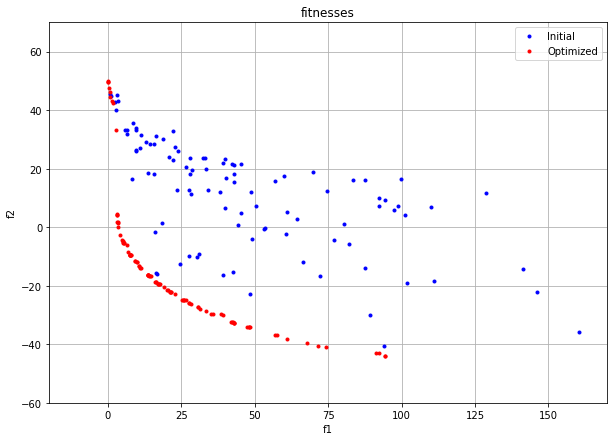

In [21]:
# 目的関数の値を確認
fitnesses_init = np.array(
    [list(pop_init[i].fitness.values) for i in range(len(pop_init))]
)
fitnesses = np.array([list(pop[i].fitness.values) for i in range(len(pop))])
# グラフで確認
plt.figure(figsize=(10, 7))
plt.plot(fitnesses_init[:, 0], fitnesses_init[:, 1], "b.", label="Initial")  # 初期世代
plt.plot(fitnesses[:, 0], fitnesses[:, 1], "r.", label="Optimized")  # 最終世代
plt.legend(loc="upper right")
plt.title("fitnesses")
# 初期の例外値が残っているのでグラフ範囲を指定
plt.xlim(-20, 170)
plt.ylim(-60, 70)
plt.xlabel("f1")
plt.ylabel("f2")
plt.grid(True)

#### ハイパーボリュームの計算

In [22]:
# 最終世代のハイパーボリュームを出力
print("Final population hypervolume is %f" % hypervolume(pop, [200.0, 100.0]))

Final population hypervolume is 27303.790898


### 最終世代の設計変数と各適応度をデータフレームで確認

In [23]:
design = pd.DataFrame(pop).rename(columns={0: "A", 1: "B", 2: "C", 3: "D"})  # 設計変数
goal = pd.DataFrame(fitnesses).rename(columns={0: "f1", 1: "f2"})  # 適応度
pd.concat([design, goal], axis=1)

,A,B,C,D,f1,f2
0,0.811545,1.069586,0.289491,2.998422,10.544124,-13.119340
1,0.874840,0.627178,0.182895,2.999973,7.768560,-9.592248
2,1.717759,1.769462,1.013173,2.999989,31.432834,-27.842890
3,1.997213,1.995419,1.328623,2.999556,41.942738,-32.256927
4,0.605698,0.444754,0.089796,2.999974,5.290934,-5.298265
...,...,...,...,...,...,...
95,0.731535,0.991062,0.241671,2.999937,9.302944,-11.673411
96,0.300351,0.864445,0.086546,2.999988,6.379851,-6.156299
97,1.236765,0.993281,0.409491,2.999955,13.735461,-16.420886
98,1.750030,1.419546,0.828100,2.999937,26.053807,-24.928556


#### 補足：比率制約を満たしているか確認

In [24]:
pd.concat([design, goal], axis=1).apply(
    lambda x: isclose((x[0] * x[1]) / (x[2] * x[3]), 1.0), axis=1
)

0     True
1     True
2     True
3     True
4     True
      ... 
95    True
96    True
97    True
98    True
99    True
Length: 100, dtype: bool

In [25]:
pd.concat([design, goal], axis=1).apply(
    lambda x: isclose((x[0] * x[1]) / (x[2] * x[3]), 1.0), axis=1
).sum()

100